## Логистическая регрессия

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Реализуйте обучение логистической регрессии с $L^1$ и $L^2$ регуляризацией с помощью метода Stochastic Gradient Descent (SGD)

#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

In [29]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, penalty="l2", verbose = False):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.penalty = penalty
        self.verbose = verbose
        
        if penalty == "l1":
            self.l1 = 1; self.l2 = 0
        elif penalty == "l2":
            self.l1 = 0; self.l2 = 1
        elif penalty == "l1l2":
            self.l1 = 1; self.l2 = 1
        elif penalty is None:
            self.l1 = 0; self.l2 = 0
        
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        assert( X.shape[0] == y.shape[0] )
        
        self.thetas = np.zeros( (X.shape[1]+1, 1) )
        self.sum_error = []
        
        self.X_y = np.hstack( (np.ones( (X.shape[0], 1) ), X ) )
        self.X_y = np.hstack( (self.X_y, y.reshape((-1, 1))) )
        
        e = 0
        
        for epoch in range( self.max_epoch ):            
                        
            np.random.shuffle( self.X_y )
            e += 1
                                   
            for row in self.X_y:               
                self.thetas -= self.alpha * \
                ( ( self.predict_proba(row[1:-1].reshape(1,-1)) - row[-1] ) * row[:-1].reshape(-1, 1) + \
                self.C * self.l1 * ( self.thetas != 0 ) + \
                self.C * self.l2 * np.abs( self.thetas ) ) 
                
            
            error = -np.sum( self.X_y[:,-1].T.dot( np.log(self.predict_proba(self.X_y[:,1:-1]))) + \
                    (1 - self.X_y[:,-1]).T.dot(1 - np.log(self.predict_proba(self.X_y[:,1:-1]))) ) / self.X_y.shape[0] - \
                    self.l1 * self.C * np.sum( np.abs(self.thetas) ) - self.l2 * self.C * np.sum( self.thetas.T.dot( self.thetas ) )
            
            self.sum_error.append( error )
            
            if self.verbose:
                print( "Thetas are ", self.thetas, "epoch is: ", e, " and error: ", error )
                
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self  
    
    def predict(self, X):
        '''
        Возвращение метки класса
        ''' 
        res = self.predict_proba( X )
        res[res>0.5] = 1
        res[res<=0.5] = 0
        return res
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        assert( X.shape[1]+1 == self.thetas.shape[0] )
        
        res = np.hstack( (np.ones( (X.shape[0], 1) ), X ) ).dot( self.thetas )
        return np.divide( np.ones(res.shape), (1 + np.exp( np.negative(res) ) ) )    
    

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

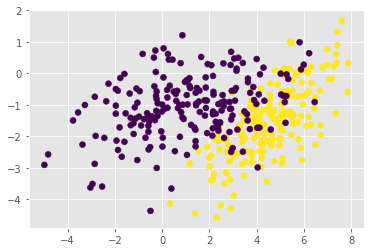

In [4]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [52]:
model = MySGDClassifier(max_epoch=10, alpha=0.05, verbose=True, penalty="l1", C=0.01)
model.fit(X, y)

Thetas are  [[-1.94045088]
 [ 0.64707137]
 [-0.41842533]] epoch is:  1  and error:  -1.0923900828815087
Thetas are  [[-3.08155862]
 [ 0.74443576]
 [-0.65683642]] epoch is:  2  and error:  -1.3603781652930897
Thetas are  [[-3.89113309]
 [ 0.8910782 ]
 [-0.82542713]] epoch is:  3  and error:  -1.5868076357108807
Thetas are  [[-4.47232173]
 [ 1.02240166]
 [-1.20318901]] epoch is:  4  and error:  -1.6930001975031184
Thetas are  [[-5.05887922]
 [ 0.83908922]
 [-1.33208809]] epoch is:  5  and error:  -1.7768945060089005
Thetas are  [[-5.49042721]
 [ 1.29715795]
 [-1.26429721]] epoch is:  6  and error:  -2.0345925813593997
Thetas are  [[-5.9129474 ]
 [ 1.12086306]
 [-1.39780615]] epoch is:  7  and error:  -2.101094029386326
Thetas are  [[-6.27834608]
 [ 1.36239127]
 [-1.4400006 ]] epoch is:  8  and error:  -2.2496999050017052
Thetas are  [[-6.56357579]
 [ 1.40622557]
 [-1.81744057]] epoch is:  9  and error:  -2.235604499516048
Thetas are  [[-6.86853093]
 [ 1.43816303]
 [-1.95174722]] epoch is

MySGDClassifier(C=0.01, alpha=0.05, max_epoch=10, penalty='l1', verbose=True)

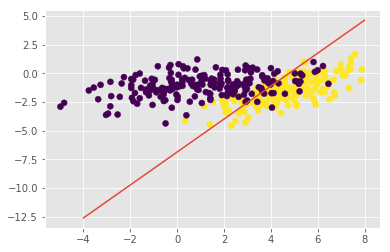

In [53]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

x_line = np.linspace(-4, 8, 100)
y_line = model.thetas[0] + model.thetas[1] * x_line
plt.plot( x_line, y_line )

## Анализ сходимости

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/эпохи (выбрать одно) для разных `alpha`.

In [54]:
## Your Code Here
epochs = [10, 25, 50]
alfs  = [0.01, 0.1, 0.05, 0.5]


In [55]:
# считаем модели при разных значениях количества эпох и альфа, регуляризацию не используем (плохо влияет)
res_for_plotting = dict()

for ep in epochs:
    for a in alfs:
        model = MySGDClassifier( alpha=a, max_epoch=ep, penalty=None)
        model.fit( X, y )
        res_for_plotting[(a, ep)] = model.sum_error

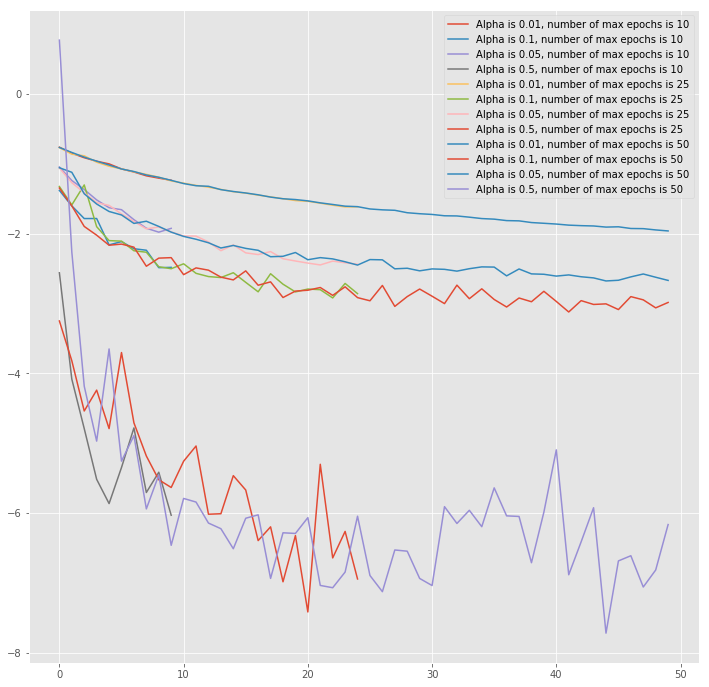

In [57]:
# рисуем графики, видно хорошо, что основное влияние оказывает количество эпох
# оптимум в районе 20 эпох, далее начинается шум вокруг горизонтальной оси
i=0
plt.figure( figsize=(12,12))
for k, v in res_for_plotting.items():
    plt.plot( v, label="Alpha is {}, number of max epochs is {}".format(k[0], k[1]), color="C{}".format(i) )
    plt.legend()    
    i = i+1 if i < 8 else 0